## Análise de Resultados

In [1]:
import sys, os
import plotly.graph_objects as go
import numpy as np

sys.path.insert(0, "/media/workspace/DeepFood/deep-reco-gym/tools/eval_viz")
import pandas as pd
import argparse
import copy
import numpy as np
import os
import random
import json
from pandas.io.json import json_normalize
from app import fetch_iteraction_results_path, load_all_iteraction_metrics
from app import load_iteractions_params as load_iteractions_params2, PATH_EVAL_REINFORCEMENT
from plot import plot_line_iteraction, plot_exploration_arm, get_colors, confidence
import pandas as pd
import argparse
import copy
import numpy as np
import streamlit as st
import seaborn as sns
sns.set(style="darkgrid")
#sys.path.insert(0, os.path.dirname(__file__))
import matplotlib.pyplot as plt
from app import load_data_metrics, load_eval_params, filter_df, fetch_results_path


In [2]:
models_and_legend = {
  "____random_":           ["bandit_policy", "observation"],
  "____fixed_":            ["bandit_policy", "observation"],
  "____lin_ucb_":          ["bandit_policy", "bandit_policy_params.alpha", "full_refit", "val_split_type"],
  "____model_":            ["bandit_policy","full_refit", "val_split_type"],
  "____custom_lin_ucb_":   ["bandit_policy", "bandit_policy_params.alpha", "full_refit", "val_split_type"],
  "____epsilon_greedy_":   ["bandit_policy","bandit_policy_params.epsilon", "full_refit", "val_split_type"],
  "____softmax_":          ["bandit_policy","bandit_policy_params.logit_multiplier", "full_refit", "val_split_type"],
  "____lin_ts_":           ["bandit_policy","bandit_policy_params.v_sq", "full_refit", "val_split_type"],
  "____percentile_adapt_":       ["bandit_policy","bandit_policy_params.exploration_threshold", "full_refit", "val_split_type"],
  "____adaptive_":         ["bandit_policy","bandit_policy_params.exploration_threshold", "bandit_policy_params.decay_rate", "full_refit", "val_split_type"],  
  "____explore_then_exp_": ["bandit_policy","bandit_policy_params.explore_rounds", "bandit_policy_params.decay_rate", "full_refit", "val_split_type"],    
}

path = PATH_EVAL_REINFORCEMENT

In [3]:
def list_paths_per_model(input_path):
    models = []
    
    for model, legend in models_and_legend.items():
    #print(model)
    #print(legend)
        for root, dirs, files in os.walk(input_path):
            if '/results' in root and 'Interaction' in root:
                for d in dirs:
                    #print(os.path.join(root, d))
                    if model in d:
                        models.append(os.path.join(root, d))
    return models

def load_iteractions_params(iteractions):
  if len(iteractions) == 0:
    return pd.DataFrame()

  dfs = []

  for model in iteractions:

    file_path = os.path.join(model, 'params.json')
    data      = []

    #try:
    with open(file_path) as json_file:
        d = json.load(json_file)
        data.append(d)

        df = pd.DataFrame.from_dict(json_normalize(data), orient='columns')
      
    #except:
    #  df = pd.DataFrame()

    df['iteraction'] = model
    dfs.append(df)
  
  return pd.concat(dfs)


def load_data_iteractions_metrics(path, sample_size = 10000):
    random.seed(42)
    file      = os.path.join(path,'sim-datalog.csv')

    # Count the lines
    num_lines = sum(1 for l in open(file)) - 1

    # Sample size - in this case ~10%
    size = np.min([sample_size, num_lines])#int(num_lines / 10)

    # The row indices to skip - make sure 0 is not included to keep the header!
    skip_idx  = sorted(random.sample(range(1, num_lines), num_lines - size))
    idx       = list(set(list(range(num_lines))) - set(skip_idx))

    df        = pd.read_csv(file, skiprows=skip_idx)
    
    df        = pd.read_csv(file)#.reset_index()
    idx       = list(range(len(df)))

    df['idx'] = sorted(idx)
    df        = df.sort_values("idx")
    return df


def get_metrics_reward(bandits):
    data    = []
    for i, p in enumerate(bandits):
        df_metrics = load_data_iteractions_metrics(p)
        r_mean     = df_metrics.reward.mean()
        r_reward   = df_metrics.reward.sum()
        data.append((i, r_mean, r_reward))
    df_metrics = pd.DataFrame(data, columns=['idx', 'r_mean', 'r_reward']).set_index('idx')    
    return df_metrics

def group_metrics(df):
    df_g_metrics = df.groupby('bandit').agg({'r_mean': ['mean', 'std'], 'r_reward': ['mean', 'std', 'count'], 'model': 'first' })
    df_g_metrics.columns = df_g_metrics.columns.map(lambda x: '|'.join([str(i) for i in x]))
    return df_g_metrics    
    
result_paths = list_paths_per_model(path)
result_paths

['output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____random_4af21be270',
 'output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____random_ec9bf13e74',
 'output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____fixed_42750d62fb',
 'output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____fixed_a0d18189af',
 'output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____fixed_4c90f2f421',
 'output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____lin_ucb_54346f9e38',
 'output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____lin_ucb_dee6885183',
 'output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____lin_ucb_72a8556eb2',
 'output/interaction/TrivagoLogi

In [4]:
fetch_results_path()

{'TrivagoLogisticModelTraining_selu____model_e3d6670bf2_684f46d0f3_ps_model': 'output/evaluation/EvaluateTrivagoTestSetPredictions/results/TrivagoLogisticModelTraining_selu____model_e3d6670bf2_684f46d0f3_ps_model',
 'TrivagoLogisticModelTraining_selu____model_a28fc6c480_cc829bb0ee_ps_model': 'output/evaluation/EvaluateTrivagoTestSetPredictions/results/TrivagoLogisticModelTraining_selu____model_a28fc6c480_cc829bb0ee_ps_model',
 'TrivagoLogisticModelInteraction_selu____adaptive_760aab7ce6_139e2b4324_ps_model': 'output/evaluation/EvaluateTrivagoTestSetPredictions/results/TrivagoLogisticModelInteraction_selu____adaptive_760aab7ce6_139e2b4324_ps_model',
 'TrivagoLogisticModelTraining_selu____model_accec28c65_63bfa01c4a_ps_model': 'output/evaluation/EvaluateTrivagoTestSetPredictions/results/TrivagoLogisticModelTraining_selu____model_accec28c65_63bfa01c4a_ps_model',
 'TrivagoLogisticModelInteraction_selu____fixed_a0d18189af_ce2d9ac8b2_ps_model': 'output/evaluation/EvaluateTrivagoTestSetPredic

## Filter Data

In [6]:
#city = "Rio de Janeiro, Brazil"
#city = "Como, Italy"
city = "Chicago, USA"
#city = "New York, USA"
#city = 'Copenhagen, Denmark'
#city='recsys'

df_params = load_iteractions_params(result_paths)
df_params = df_params[df_params['data_frames_preparation_extra_params.filter_city'] == city]
df_params.head()

/home/marlesson/anaconda3/envs/deep-reco-gym/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,activation_function,balance_fields,bandit_policy,bandit_policy_params.alpha,bandit_policy_params.arg,bandit_policy_params.decay_rate,bandit_policy_params.epsilon,bandit_policy_params.exploration_threshold,bandit_policy_params.explore_rounds,bandit_policy_params.logit_multiplier,...,sampling_strategy,seed,session_test_size,split_index,test_size,test_split_type,use_sampling_in_validation,val_size,val_split_type,weight_init
0,selu,[],random,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.2,time,False,0.2,random,lecun_normal
0,selu,[],random,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.2,time,False,0.2,random,lecun_normal
0,selu,[],fixed,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.2,time,False,0.2,random,lecun_normal
0,selu,[],fixed,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.2,time,False,0.2,random,lecun_normal
0,selu,[],fixed,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.2,time,False,0.2,random,lecun_normal


In [7]:
df_params

,activation_function,balance_fields,bandit_policy,bandit_policy_params.alpha,bandit_policy_params.arg,bandit_policy_params.decay_rate,bandit_policy_params.epsilon,bandit_policy_params.exploration_threshold,bandit_policy_params.explore_rounds,bandit_policy_params.logit_multiplier,...,sampling_strategy,seed,session_test_size,split_index,test_size,test_split_type,use_sampling_in_validation,val_size,val_split_type,weight_init
0,selu,[],random,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.2,time,False,0.2,random,lecun_normal
0,selu,[],random,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.2,time,False,0.2,random,lecun_normal
0,selu,[],fixed,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.2,time,False,0.2,random,lecun_normal
0,selu,[],fixed,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.2,time,False,0.2,random,lecun_normal
0,selu,[],fixed,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.2,time,False,0.2,random,lecun_normal
0,selu,[],lin_ucb,0.00001,NaN,NaN,NaN,NaN,NaN,NaN,...,none,4,0.1,0,0.2,time,False,0.2,random,lecun_normal
0,selu,[],lin_ucb,0.00001,NaN,NaN,NaN,NaN,NaN,NaN,...,none,10,0.1,0,0.2,time,False,0.2,random,lecun_normal
0,selu,[],lin_ucb,0.00001,NaN,NaN,NaN,NaN,NaN,NaN,...,none,2,0.1,0,0.2,time,False,0.2,random,lecun_normal
0,selu,[],lin_ucb,0.00001,NaN,NaN,NaN,NaN,NaN,NaN,...,none,5,0.1,0,0.2,time,False,0.2,random,lecun_normal
0,selu,[],lin_ucb,0.00001,NaN,NaN,NaN,NaN,NaN,NaN,...,none,6,0.1,0,0.2,time,False,0.2,random,lecun_normal


In [10]:
list_bandits          = df_params.groupby(["bandit_policy", "observation"])['iteraction'].apply(list).reset_index()
list_bandits['name']  = list_bandits.bandit_policy.map(str) + ' ' + list_bandits.observation.map(str)
list_bandits['name']  = list_bandits['name'].apply(lambda x: x.replace("fixed ", "").replace(" ", ""))
list_bandits['model'] = list_bandits.iteraction.apply(lambda l: l[np.random.randint(0, len(l))])
list_bandits['model_list'] = list_bandits.iteraction
list_bandits

,bandit_policy,observation,iteraction,name,model,model_list
0,adaptive,,"[output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_8dd93c9b62, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_760aab7ce6, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_293795b094, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_980bbe629a, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_22f7b130c2, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_fc270e33e2]",adaptive,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_22f7b130c2,"[output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_8dd93c9b62, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_760aab7ce6, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_293795b094, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_980bbe629a, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_22f7b130c2, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_fc270e33e2]"
1,custom_lin_ucb,,"[output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_98b4587df1, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_198409b3bb, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_a43a7084ff, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_8b22c99f6f, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_9873a64753, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_5e37da5eac]",custom_lin_ucb,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_9873a64753,"[output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_98b4587df1, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_198409b3bb, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_a43a7084ff, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_8b22c99f6f, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_9873a64753, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_5e37da5eac]"
2,epsilon_greedy,,"[output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_f361d883d5, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_cdad648430, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_b041a84da1, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_bb63836647, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_200d4e90c8, output/interaction/TrivagoLo

In [11]:
#df_params

,activation_function,balance_fields,bandit_policy,bandit_policy_params.alpha,bandit_policy_params.arg,bandit_policy_params.decay_rate,bandit_policy_params.epsilon,bandit_policy_params.exploration_threshold,bandit_policy_params.explore_rounds,bandit_policy_params.logit_multiplier,...,sampling_strategy,seed,session_test_size,split_index,test_size,test_split_type,use_sampling_in_validation,val_size,val_split_type,weight_init
0,selu,[],random,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.2,time,False,0.2,random,lecun_normal
0,selu,[],random,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.2,time,False,0.2,random,lecun_normal
0,selu,[],fixed,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.2,time,False,0.2,random,lecun_normal
0,selu,[],fixed,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.2,time,False,0.2,random,lecun_normal
0,selu,[],fixed,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,none,42,0.1,0,0.2,time,False,0.2,random,lecun_normal
0,selu,[],lin_ucb,0.00001,NaN,NaN,NaN,NaN,NaN,NaN,...,none,4,0.1,0,0.2,time,False,0.2,random,lecun_normal
0,selu,[],lin_ucb,0.00001,NaN,NaN,NaN,NaN,NaN,NaN,...,none,10,0.1,0,0.2,time,False,0.2,random,lecun_normal
0,selu,[],lin_ucb,0.00001,NaN,NaN,NaN,NaN,NaN,NaN,...,none,2,0.1,0,0.2,time,False,0.2,random,lecun_normal
0,selu,[],lin_ucb,0.00001,NaN,NaN,NaN,NaN,NaN,NaN,...,none,5,0.1,0,0.2,time,False,0.2,random,lecun_normal
0,selu,[],lin_ucb,0.00001,NaN,NaN,NaN,NaN,NaN,NaN,...,none,6,0.1,0,0.2,time,False,0.2,random,lecun_normal


## Geral

In [12]:
reward_metrics = []

In [13]:
for i, row in list_bandits.iterrows():
    df_metrics = get_metrics_reward(row['iteraction'])
    df_metrics['bandit'] = row['name']
    df_metrics['model']  = row['model']

    df_g_metrics = group_metrics(df_metrics)
    reward_metrics.append(df_g_metrics)

In [14]:
df_all = pd.concat(reward_metrics)
df_all = df_all.reset_index().sort_values('bandit', ascending=False).set_index('bandit')
df_all

,r_mean|mean,r_mean|std,r_reward|mean,r_reward|std,r_reward|count,model|first
bandit,,,,,,
softmax_explorer,0.308273,0.005153,3260.600000,54.505046,5,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____softmax_explorer_0dc2efb3be
random,0.041883,0.000000,443.000000,0.000000,2,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____random_ec9bf13e74
percentile_adaptive,0.310926,0.004280,3288.666667,45.271036,6,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____percentile_adapt_0c3f7806b6
model,0.322744,0.018139,3413.666667,191.858976,6,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____model_1a47c744c6
lin_ucb,0.133051,0.004140,1407.285714,43.786277,7,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____lin_ucb_fa9e15fd00
explore_then_exploit,0.233696,0.007407,2471.800000,78.343475,5,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____explore_then_exp_f8fa5151f5
epsilon_greedy,0.293372,0.011878,3103.000000,125.632798,6,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_fdfe457693
custom_lin_ucb,0.323627,0.004051,3423.000000,42.848571,6,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_9873a64753
adaptive,0.241152,0.008324,2550.666667,88.046957,6,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_22f7b130c2


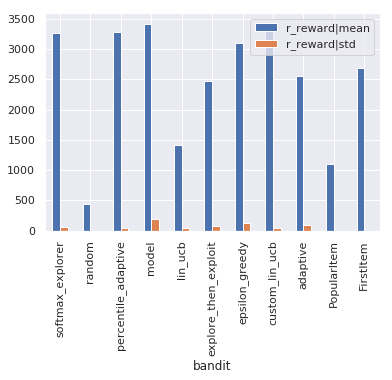

In [15]:
df_all[['r_reward|mean', 'r_reward|std']].plot(kind='bar')

In [16]:
df_all.to_csv("output/tmp/stats.csv")

## Plot Test

In [17]:
list_bandits['name'] = list_bandits['name'].apply(lambda x: "popular_item" if x == "PopularItem" else x)
df_models = list_bandits.set_index('name')[['model_list']]
df_models

,model_list
name,
adaptive,"[output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_8dd93c9b62, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_760aab7ce6, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_293795b094, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_980bbe629a, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_22f7b130c2, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____adaptive_fc270e33e2]"
custom_lin_ucb,"[output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_98b4587df1, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_198409b3bb, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_a43a7084ff, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_8b22c99f6f, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_9873a64753, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____custom_lin_ucb_5e37da5eac]"
epsilon_greedy,"[output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_f361d883d5, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_cdad648430, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_b041a84da1, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_bb63836647, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_200d4e90c8, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____epsilon_greedy_fdfe457693]"
explore_then_exploit,"[output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____explore_then_exp_c7a5be6706, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____explore_then_exp_5b5520d57f, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____explore_then_exp_f8fa5151f5, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____explore_then_exp_dceb5aee1e, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____explore_then_exp_9df2c46d81]"
FirstItem,[output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____fixed_42750d62fb]
popular_item,"[output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____fixed_a0d18189af, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____fixed_4c90f2f421]"
lin_ucb,"[output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____lin_ucb_54346f9e38, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____lin_ucb_dee6885183, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____lin_ucb_72a8556eb2, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____lin_ucb_236db161c6, output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____lin_ucb_a7975cce57, output/interaction/TrivagoLogisticModelInteraction/resu

In [18]:
df_models.index

Index(['adaptive', 'custom_lin_ucb', 'epsilon_greedy', 'explore_then_exploit',
       'FirstItem', 'popular_item', 'lin_ucb', 'model', 'percentile_adaptive',
       'random', 'softmax_explorer'],
      dtype='object', name='name')

In [23]:
bandits           = ['adaptive', 'custom_lin_ucb', 'epsilon_greedy', 'explore_then_exploit',
                       'popular_item',  'lin_ucb', 'percentile_adaptive', 'random', 'softmax_explorer']

sample_size       = 15000
window_size       = 1000 

In [24]:
def load_dataset(df_models, bandits, sample_size):
    data = []
    for bandit in bandits:
        input_iteraction  = [p.split("/")[-1] for p in df_models.loc[bandit].model_list]
        df_metrics        = load_all_iteraction_metrics(input_iteraction, sample_size)
        #params            = load_iteractions_params2(input_iteraction)
        
        
        df_metrics        = load_all_iteraction_metrics(input_iteraction, sample_size)
        df_metrics['_idx'] = 1
        df_metrics        = df_metrics.groupby(['iteraction', 'idx']).sum().fillna(0).groupby(level=0).cumsum().reset_index()
        df_metrics['mean_reward'] = (df_metrics.reward/df_metrics._idx).fillna(0)
        df_metrics['bandit']      = bandit
        
        data.append(df_metrics)
    return pd.concat(data, ignore_index=True)

df_group = load_dataset(df_models, bandits, sample_size)
df_group.head()

,iteraction,idx,user,item,reward,ps,index_env,_idx,mean_reward,bandit
0,TrivagoLogisticModelInteraction_selu____adaptive_22f7b130c2,0,837,128,0.0,0.975610,10,1,0.0,adaptive
1,TrivagoLogisticModelInteraction_selu____adaptive_22f7b130c2,1,1674,530,0.0,1.951220,43,2,0.0,adaptive
2,TrivagoLogisticModelInteraction_selu____adaptive_22f7b130c2,2,2511,887,0.0,2.926829,96,3,0.0,adaptive
3,TrivagoLogisticModelInteraction_selu____adaptive_22f7b130c2,3,2514,1064,0.0,3.902439,186,4,0.0,adaptive
4,TrivagoLogisticModelInteraction_selu____adaptive_22f7b130c2,4,3597,1157,0.0,4.878049,297,5,0.0,adaptive


In [25]:
# input_iteraction  = [p.split("/")[-1] for p in df_models.loc['adaptive'].model_list]

# df_metrics        = load_all_iteraction_metrics(input_iteraction, sample_size)
# df_metrics        = df_metrics.groupby(['iteraction', 'idx']).sum().fillna(0).groupby(level=0).cumsum().reset_index()
# df_metrics['mean_reward'] = (df_metrics.reward/df_metrics.idx).fillna(0)
# df_metrics

In [26]:
def plot_cum_reward(df, hue='bandit', legend=False, ylim=1):
    plt.figure()
    sns.set(style="darkgrid")

    # Plot the responses for different events and regions
    ax =  sns.lineplot(x="idx", y="mean_reward", hue=hue, legend=legend, data=df)
    ax.set_ylim(0,ylim)
    #ax.set(xlabel='Interactions', ylabel='Cumulative Mean Reward',fontsize=20)
    ax.tick_params(labelsize=11)
    ax.set_xlabel('Interactions',fontsize=15);
    ax.set_ylabel('Cumulative Mean Reward',fontsize=15);
    # Put the legend out of the figure
    if legend:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=12)
    plt.savefig("output/tmp/iteraction.pdf",dpi=300, bbox_inches="tight")
    plt.show()

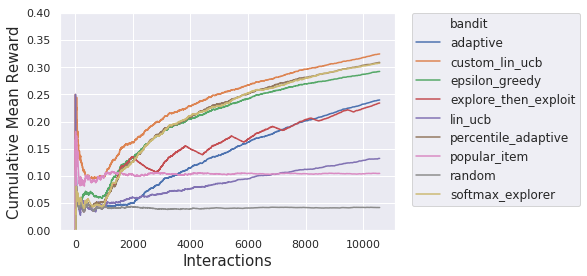

In [28]:
_df = df_group.groupby(['bandit', 'idx']).median().reset_index()
plot_cum_reward(_df, legend='full', ylim=0.4)

In [29]:
df_metrics
# df_group = load_dataset(df_models, bandits, 20000)
# plot_cum_reward(df_group, hue='bandit', legend='full')

,r_mean,r_reward,bandit,model
idx,,,,
0,0.315780,3340.0,softmax_explorer,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____softmax_explorer_0dc2efb3be
1,0.310107,3280.0,softmax_explorer,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____softmax_explorer_0dc2efb3be
2,0.306420,3241.0,softmax_explorer,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____softmax_explorer_0dc2efb3be
3,0.307270,3250.0,softmax_explorer,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____softmax_explorer_0dc2efb3be
4,0.301787,3192.0,softmax_explorer,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____softmax_explorer_0dc2efb3be


In [30]:
df_group

,iteraction,idx,user,item,reward,ps,index_env,_idx,mean_reward,bandit
0,TrivagoLogisticModelInteraction_selu____adaptive_22f7b130c2,0,837,128,0.0,0.975610,10,1,0.000000,adaptive
1,TrivagoLogisticModelInteraction_selu____adaptive_22f7b130c2,1,1674,530,0.0,1.951220,43,2,0.000000,adaptive
2,TrivagoLogisticModelInteraction_selu____adaptive_22f7b130c2,2,2511,887,0.0,2.926829,96,3,0.000000,adaptive
3,TrivagoLogisticModelInteraction_selu____adaptive_22f7b130c2,3,2514,1064,0.0,3.902439,186,4,0.000000,adaptive
4,TrivagoLogisticModelInteraction_selu____adaptive_22f7b130c2,4,3597,1157,0.0,4.878049,297,5,0.000000,adaptive
...,...,...,...,...,...,...,...,...,...,...
475960,TrivagoLogisticModelInteraction_selu____softmax_explorer_87f6058d5e,10572,6121525,2161835,3240.0,2910.789346,196488387,10573,0.306441,softmax_explorer
475961,TrivagoLogisticModelInteraction_selu____softmax_explorer_87f6058d5e,10573,6122587,2162003,3240.0,2910.841169,196525272,10574,0.306412,softmax_explorer
475962,TrivagoLogisticModelInteraction_selu____softmax_explorer_87f6058d5e,10574,6123649,2162171,3240.0,2910.881147,196562182,10575,0.306383,softmax_explorer
475963,TrivagoLogisticModelInteraction_selu____softmax_explorer_87f6058d5e,10575,6124393,2162462,3241.0,2910.921316,196599138,10576,0.306449,softmax_explorer


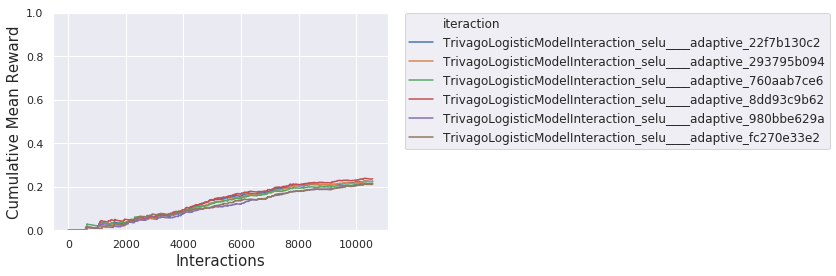

In [31]:
df_group = load_dataset(df_models, ['adaptive'], 1000)
df_group
plot_cum_reward(df_group, hue='iteraction', legend='full')

In [32]:
df_group.head()

,iteraction,idx,user,item,reward,ps,index_env,_idx,mean_reward,bandit
0,TrivagoLogisticModelInteraction_selu____adaptive_22f7b130c2,0,1083,93,0.0,0.975610,111,1,0.0,adaptive
1,TrivagoLogisticModelInteraction_selu____adaptive_22f7b130c2,5,1625,487,0.0,1.951220,310,2,0.0,adaptive
2,TrivagoLogisticModelInteraction_selu____adaptive_22f7b130c2,8,2037,738,0.0,2.926829,633,3,0.0,adaptive
3,TrivagoLogisticModelInteraction_selu____adaptive_22f7b130c2,13,2211,773,0.0,3.902439,1111,4,0.0,adaptive
4,TrivagoLogisticModelInteraction_selu____adaptive_22f7b130c2,20,3048,901,0.0,4.878049,1702,5,0.0,adaptive


In [33]:
# sns.set(style="darkgrid")

# # Plot the responses for different events and regions
# ax =  sns.lineplot(x="idx", y="mean_reward", hue='bandit', legend=False, data=df_group)
# ax.set_ylim(0,0.35)
# ax.set(xlabel='Interactions', ylabel='Cumulative Mean Reward')

# # Put the legend out of the figure
# #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.savefig("output/tmp/iteraction.pdf",dpi=300)
# plt.show()

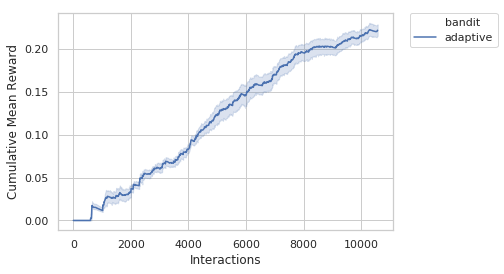

In [34]:
sns.set_style("whitegrid")

# Plot the responses for different events and regions
ax =  sns.lineplot(x="idx", y="mean_reward", hue='bandit', legend='full', data=df_group)
ax.set(xlabel='Interactions', ylabel='Cumulative Mean Reward')

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("output/tmp/iteraction_2.png",dpi=300)

plt.show()

## Plot

In [ ]:

removed           = df_all.loc[['model ', 'FirstItem']]['model|first'].values

input_legend      = ['bandit_policy', 'observation']
input_iteraction  = [p.split("/")[-1] for p in df_all['model|first'] if p not in removed]
sample_size       = 10000
window_size       = 1000 

st.set_option("client.displayEnabled", False)

metrics           = load_all_iteraction_metrics(input_iteraction, sample_size)
params            = load_iteractions_params2(input_iteraction)

df_metrics_reward = metrics.groupby("iteraction").agg({'reward': ['mean', 'sum']}).reset_index().sort_values([('reward', 'sum')], ascending=False)

df  = metrics.merge(params, on=['iteraction'], how='left')\
            .merge(metrics.groupby("iteraction")\
                    .agg({'reward': 'mean'})\
                    .rename(columns={'reward': 'sum_reward'})\
                    .reset_index(), 
              on=['iteraction'], how='left')\
            .reset_index()\
            .sort_values(['sum_reward', 'idx'], ascending=[False, True])


df.to_pickle('output/tmp/iteraction_df.pkl')
df.head()

In [ ]:
df

In [ ]:
df

In [ ]:
df = df[df.bandit_policy != "model"]

In [ ]:
k = 100
for i in range(k):
    
    for input_metrics in ['Cumulative Window Mean Reward', 'Cumulative Mean Reward']:

        #input_metrics = 'Cumulative Mean Reward'
        fig = plot_line_iteraction(df[df.idx < int((df.idx.max()/k) *i)], 'reward', 
                              title=input_metrics, 
                              legend=input_legend,
                              yrange=[0, 0.35], 
                              line_dict=get_colors(input_iteraction),
                              window=window_size,
                              cum=(input_metrics == 'Cumulative Reward'), 
                              mean=(input_metrics == 'Cumulative Mean Reward'),
                              roll=(input_metrics == 'Cumulative Window Mean Reward'))
        fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False)
        fig.update_layout(font={'family': 'Courier New, monospace', 'size': 14}, height=550)
        fig.update_yaxes(range=[0, 0.5])
        fig.update_xaxes(range=[0, df.idx.max()])
        #fig.show(renderer="svg")
        fig.write_image("output/tmp/interactions/{}_{}.png".format(input_metrics, i)) #, width=1024, height=600, scale=2
        print(i,"... ")

In [ ]:
df = pd.read_pickle('output/tmp/iteraction_df.pkl')

# GERAL
for input_metrics in ['Cumulative Reward', 'Cumulative Window Mean Reward', 'Cumulative Mean Reward']:
    #input_metrics = 'Cumulative Mean Reward'
    fig = plot_line_iteraction(df, 'reward', 
                          title=input_metrics, 
                          legend=input_legend,
                          yrange=[0, 0.35], 
                          line_dict=get_colors(input_iteraction),
                          window=window_size,
                          cum=(input_metrics == 'Cumulative Reward'), 
                          mean=(input_metrics == 'Cumulative Mean Reward'),
                          roll=(input_metrics == 'Cumulative Window Mean Reward'))
    fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, title="{} - dataset".format(city))
    fig.update_layout(font={'family': 'Courier New, monospace', 'size': 14}, height=550)
    fig.show(renderer="svg")

    fig.write_image("output/tmp/iteraction_{}.eps".format(input_metrics.replace(" ", "_"))) #, width=1024, height=600, scale=2

## Recsys Metrics

In [130]:
from app import load_data_metrics, load_eval_params, filter_df, fetch_results_path
from plot import plot_bar

RECSYS_METRICS = [
  "count",
  "mean_average_precision",
  "precision_at_1",
  "ndcg_at_5",
  "ndcg_at_10",
  "ndcg_at_15",
  "ndcg_at_20",
  "ndcg_at_50",
  "coverage_at_5",
  "coverage_at_10",
  "coverage_at_15",
  "coverage_at_20",
  "coverage_at_50",
  "personalization_at_5",
  "personalization_at_10",
  "personalization_at_15",
  "personalization_at_20",
  "personalization_at_50",
  "IPS",
  "CIPS",
  "SNIPS",
  "DirectEstimator",
  "DoublyRobust"]


input_metrics = [
  "precision_at_1",
  "ndcg_at_5",
  "coverage_at_5",
  "personalization_at_5",
  "IPS",
  "CIPS",
  "SNIPS",
  "DirectEstimator",
  "DoublyRobust"
]

In [131]:
input_models_eval = fetch_results_path().keys()
input_params      = []
input_models_eval

dict_keys(['TrivagoLogisticModelTraining_selu____model_e3d6670bf2_684f46d0f3_ps_model', 'TrivagoLogisticModelInteraction_selu____custom_lin_ucb_198409b3bb_ca95b4b8eb_ps_model', 'TrivagoLogisticModelInteraction_selu____explore_then_exp_5b5520d57f_f9e24b8c53_ps_model', 'TrivagoLogisticModelTraining_selu____model_a28fc6c480_cc829bb0ee_ps_model', 'TrivagoLogisticModelInteraction_selu____lin_ucb_28b3e75412_e821458d9f_ps_model', 'TrivagoLogisticModelInteraction_selu____model_2b49e2698c_10e6f68b8a_ps_model', 'TrivagoLogisticModelInteraction_selu____adaptive_760aab7ce6_139e2b4324_ps_model', 'TrivagoLogisticModelTraining_selu____model_accec28c65_63bfa01c4a_ps_model', 'TrivagoLogisticModelInteraction_selu____explore_then_exp_dceb5aee1e_e7c85bff6a_ps_model', 'TrivagoLogisticModelInteraction_selu____fixed_a0d18189af_ce2d9ac8b2_ps_model', 'TrivagoLogisticModelInteraction_selu____lin_ucb_54346f9e38_b720e44c33_ps_model', 'TrivagoLogisticModelInteraction_selu____model_309e30213b_2ef95cf81e_ps_model', 

In [132]:
data_metrics       = load_data_metrics()
data_params        = load_eval_params()

df_metrics         = filter_df(data_metrics, input_models_eval, input_metrics, "")
df_eval_params     = filter_df(data_params, input_models_eval, input_params).transpose()

In [133]:
df_params[['iteraction']]

,iteraction
0,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____random_4af21be270
0,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____random_ec9bf13e74
0,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____fixed_42750d62fb
0,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____fixed_a0d18189af
0,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____fixed_4c90f2f421
0,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____lin_ucb_54346f9e38
0,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____lin_ucb_dee6885183
0,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____lin_ucb_72a8556eb2
0,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____lin_ucb_236db161c6
0,output/interaction/TrivagoLogisticModelInteraction/results/TrivagoLogisticModelInteraction_selu____lin_ucb_a7975cce57


In [134]:
confidence_metrics = data_metrics[[c for c in data_metrics.columns if "_C" in c]]
for c in input_metrics:
    c_column = c+"_C" 
    confidence_metrics[c_column] = data_metrics[c_column] if c_column in data_metrics else None
confidence_metrics = confidence_metrics[[c+"_C" for c in input_metrics]]

In [135]:
# fig = plot_bar(df_metrics, confidence = confidence_metrics, title="Comparison of Recsys Metrics")

# fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False)
# fig.update_layout(font={'family': 'Courier New, monospace', 'size': 14}, height=550)
# fig.show(renderer="svg")

# #fig.write_image("output/tmp/metrics/recsys_rank.eps")

In [136]:
#confidence_metrics

In [137]:
df_metrics.round(3)

,precision_at_1,ndcg_at_5,coverage_at_5,personalization_at_5,IPS,CIPS,SNIPS,DirectEstimator,DoublyRobust
path,,,,,,,,,
TrivagoLogisticModelTraining_selu____model_e3d6670bf2_684f46d0f3_ps_model,0.316,0.434,0.288,0.743,0.290,0.180,0.311,0.193,0.275
TrivagoLogisticModelInteraction_selu____custom_lin_ucb_198409b3bb_ca95b4b8eb_ps_model,0.305,0.401,0.364,0.729,0.294,0.174,0.297,0.175,0.270
TrivagoLogisticModelInteraction_selu____explore_then_exp_5b5520d57f_f9e24b8c53_ps_model,0.318,0.418,0.327,0.740,0.310,0.181,0.321,0.165,0.272
TrivagoLogisticModelTraining_selu____model_a28fc6c480_cc829bb0ee_ps_model,0.342,0.452,0.306,0.731,0.329,0.193,0.336,0.197,0.307
TrivagoLogisticModelInteraction_selu____lin_ucb_28b3e75412_e821458d9f_ps_model,0.072,0.194,0.288,0.733,0.061,0.039,0.059,0.031,0.045
...,...,...,...,...,...,...,...,...,...
TrivagoLogisticModelInteraction_selu____percentile_adapt_0d94e656f7_12737353e7_ps_model,0.310,0.448,0.372,0.733,0.301,0.175,0.297,0.167,0.268
TrivagoLogisticModelTraining_selu____model_edef58e79d_6ccdc0fb88_ps_model,0.340,0.420,0.302,0.741,0.372,0.193,0.371,0.195,0.351
TrivagoLogisticModelInteraction_selu____epsilon_greedy_fdfe457693_39f960c664_ps_model,0.321,0.455,0.345,0.725,0.316,0.181,0.339,0.172,0.288


In [138]:
df_metrics['bandit'] = list(df_metrics.reset_index().path.apply(lambda x: x.split("____")[1].split("_")[0]))
df_group = df_metrics.groupby('bandit').mean()
df_group['count'] = df_metrics.groupby('bandit').count()['precision_at_1']
df_group.round(3)

,precision_at_1,ndcg_at_5,coverage_at_5,personalization_at_5,IPS,CIPS,SNIPS,DirectEstimator,DoublyRobust,count
bandit,,,,,,,,,,
adaptive,0.331,0.415,0.379,0.770,0.314,0.188,0.331,0.181,0.291,6
custom,0.338,0.443,0.371,0.724,0.324,0.191,0.319,0.180,0.299,6
epsilon,0.311,0.441,0.343,0.737,0.305,0.177,0.322,0.165,0.278,6
explore,0.315,0.423,0.313,0.737,0.308,0.179,0.316,0.167,0.280,5
fixed,0.074,0.199,0.154,0.592,0.063,0.039,0.052,0.046,0.062,1
lin,0.065,0.183,0.297,0.721,0.047,0.031,0.049,0.033,0.043,7
model,0.349,0.444,0.305,0.730,0.342,0.198,0.350,0.194,0.316,28
percentile,0.319,0.426,0.364,0.750,0.306,0.180,0.307,0.171,0.279,6
random,0.042,0.146,0.392,0.777,0.029,0.023,0.032,0.025,0.029,1


In [139]:
df_group.round(3).to_csv("output/tmp/df_metrics_recsys.csv")

## Fainess

In [ ]:
from app import load_fairness_metrics, load_fairness_df
#from plot import plot_fairness_mistreatment
from app import load_data_metrics, load_eval_params, filter_df, fetch_results_path

TEMPLATE = 'plotly_white' #simple_white

def plot_fairness_mistreatment(df, metric, title=""):
    data = []

    data.append(go.Bar(y=df.index, x=df[metric], orientation='h',
                    error_x= dict(type='data', array=df[metric+"_C"]) if metric+"_C" in df.columns else {}  ,
                    marker={'color': list(range(len(df.index))), 
                            'colorscale': 'Tealgrn'})) #Plotly3

    fig = go.Figure(data=data)
    # Change the bar mode
    fig.update_layout(template=TEMPLATE, legend_orientation="h", 
                    xaxis_title=metric,
                    legend=dict(y=-0.2), title=title)
    #fig.update_traces(texttemplate='%{x:.2f}', textposition='outside')

    fig.update_layout(shapes=[
      dict(
        type= 'line',
        line=dict(
            width=1,
            dash="dot",
        ),        
        yref='paper', y0= 0, y1= 1,
        xref='x', x0= df[metric].mean(), x1= df[metric].mean()
      )
    ])

    st.plotly_chart(fig)

    return fig

### current_filters_sort_by_price

In [ ]:

input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
input_features    = 'current_filters_sort_by_price'
input_metrics     = 'true_positive_rate'


In [ ]:
fetch_results_path()

In [ ]:
def plot_fairness_metrics(input_models_eval, input_features, input_metrics, sub_map = None):
    df_all_metrics    = load_fairness_metrics().loc[input_models_eval]
    df_instances      = load_fairness_df().loc[input_models_eval]
    df_all_metric_filter = df_all_metrics[df_all_metrics.sub_key.isin([input_features])]

    columns         = list(np.unique(['sub_key', 'sub', 'feature', 'total_class', 'total_individuals'] + [input_metrics]))
    if input_metrics+"_C" in df_all_metrics.columns:
        columns.append(input_metrics+"_C")

    df_metrics      = filter_df(df_all_metrics, input_models_eval, columns, 'sub')

    df_metrics      = df_metrics[df_metrics.sub_key.isin([input_features])]
    if sub_map != None:
        df_metrics['sub'] = df_metrics['sub'].map(sub_map)
    
    df_metrics      = df_metrics.sort_values("feature").set_index("sub")
    df_metrics      = df_metrics.sort_values(input_metrics)
    df_metrics
    
    fig = plot_fairness_mistreatment(df_metrics, input_metrics, title="")
    #title="Disparate Mistreatment: "+input_features
    
    fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, yaxis_title=input_features)
    fig.update_layout(font={'family': 'Courier New, monospace', 'size': 17}, height=550)

    
    df_total     = df_metrics[['total_class', 'total_individuals']]
    df_total_sum = df_total.sum(numeric_only=True)
    df_percent   = df_total/df_total_sum
    df_total     = df_total.apply(lambda row: ["{} ({:.2f} %)".format(i, p*100) for i,p in zip(row, df_percent[row.name])])
    df_total.loc['total'] = df_total_sum
    df_total.head(10)    
    
    return fig, df_metrics, df_total

In [ ]:
fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, input_features, input_metrics,
                                                 sub_map = {'1.0': 'True', '0.0': 'False'})

#fig.update_layout(scene = dict(xaxis = dict(tickfont=dict(size = 5, color='green'))))

In [ ]:
fig.show(renderer="svg")



fig.write_image("output/tmp/metrics/recsys_fairnes_{}.eps".format(input_features))    

In [ ]:
df_metrics.head()

In [ ]:
df_total.head()

### current_filters_sort_by_price

In [ ]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_224970e314_cccf64b73d_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
input_features    = 'city_idx'
input_metrics     = 'true_positive_rate'

In [ ]:
input_models_eval

In [ ]:
# sub_map = {'0': "Boston, USA",
#             '1': "Como, Italy",
#             '2': "Chicago, USA",
#             '3': "Lausanne, Switzerland",
#             '4': "Dublin, Ireland",
#             '5': "Rio de Janeiro, Brazil",
#             '6': "Barcelona, Spain",
#             '7': "Copenhagen, Denmark",
#             '8': "Vienna, Austria",
#             '9': "New York, USA",
#             '10': "Hong Kong, Hong Kong",
#             '11': "Vancouver, Canada"}

sub_map = {'0': "Boston",
            '1': "Como",
            '2': "Chicago",
            '3': "Lausanne",
            '4': "Dublin",
            '5': "Rio de Janeiro",
            '6': "Barcelona",
            '7': "Copenhagen",
            '8': "Vienna",
            '9': "New York",
            '10': "Hong Kong",
            '11': "Vancouver"}


fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, input_features, input_metrics,
                                                 sub_map = sub_map)

In [ ]:

# Set custom x-axis labels
fig.update_xaxes(nticks=4)

fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, yaxis_title="City")
fig.update_layout(font={'family': 'Courier New, monospace', 'size': 20}, height=600)



fig.show(renderer="svg")
fig.write_image("output/tmp/metrics/paper/recsys_fairnes_{}.eps".format(input_features))    

In [ ]:
df_metrics.head(50)

In [ ]:
df_total.head()

### acessible hotel/park

In [ ]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_224970e314_43d5853a51_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
input_features    = 'accessible hotel'
input_metrics     = 'true_positive_rate'

In [ ]:
fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, input_features, input_metrics,
                                                 sub_map = None)
fig.show(renderer="svg")

In [ ]:
fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, 'accessible parking', input_metrics,
                                                 sub_map = None)
fig.show(renderer="svg")

In [ ]:
input_features
sub_map = None

In [ ]:
import plotly.express as px
print(px.colors.sequential.Tealgrn)

In [ ]:
metrics = []


def plot_fairness_mistreatment(df, metric, title=""):
    data = []

    data.append(go.Bar(y=df.index, x=df[metric], orientation='h',
                    error_x= dict(type='data', array=df[metric+"_C"]) if metric+"_C" in df.columns else {}  ,
                    marker={'color': [px.colors.sequential.Tealgrn[i] for i in df.color]})) #Plotly3

    fig = go.Figure(data=data)
    # Change the bar mode
    fig.update_layout(template=TEMPLATE, legend_orientation="h", 
                    xaxis_title=metric,
                    legend=dict(y=-0.2), title=title)
    #fig.update_traces(texttemplate='%{x:.2f}', textposition='outside')

    fig.update_layout(shapes=[
      dict(
        type= 'line',
        line=dict(
            width=1,
            dash="dot",
        ),        
        yref='paper', y0= 0, y1= 1,
        xref='x', x0= df[metric].mean(), x1= df[metric].mean()
      )
    ])

    st.plotly_chart(fig)

    return fig

for input_features in ['accessible parking', 'accessible hotel']:
    df_all_metrics    = load_fairness_metrics().loc[input_models_eval]
    df_instances      = load_fairness_df().loc[input_models_eval]
    df_all_metric_filter = df_all_metrics[df_all_metrics.sub_key.isin([input_features])]

    columns         = list(np.unique(['sub_key', 'sub', 'feature', 'total_class', 'total_individuals'] + [input_metrics]))
    if input_metrics+"_C" in df_all_metrics.columns:
        columns.append(input_metrics+"_C")

    df_metrics      = filter_df(df_all_metrics, input_models_eval, columns, 'sub')

    df_metrics      = df_metrics[df_metrics.sub_key.isin([input_features])]
    if sub_map != None:
        df_metrics['sub'] = df_metrics['sub'].map(sub_map)

    df_metrics      = df_metrics.sort_values("feature").set_index("sub")
    df_metrics      = df_metrics.sort_values(input_metrics)
    metrics.append(df_metrics)

metrics = pd.concat(metrics)
metrics

In [ ]:
metrics.reset_index()
metrics['sub'] = ['parking<br>True', 'parking<br>False', 'hotel<br>True', 'hotel<br>False']
metrics['color'] = [2,2, 5,5]
metrics = metrics.set_index('sub')
metrics

In [ ]:
fig = plot_fairness_mistreatment(metrics, input_metrics, title="")

fig.update_layout(shapes=[
  dict(
    type= 'line',
    line=dict(
        width=1,
        dash="dot",
    ),        
    xref='paper', x0= 0, x1= 1,
    yref='y',     y0= 1.5, y1= 1.5
  )
])

# Set custom x-axis labels
fig.update_xaxes(nticks=4)

fig.update_layout(yaxis={'categoryorder':'array', 'categoryarray':['parking<br>False', 'parking<br>True', 'hotel<br>False', 'hotel<br>True']})
fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, yaxis_title="Accessible")
fig.update_layout(font={'family': 'Courier New, monospace', 'size': 22}, height=550)

fig.write_image("output/tmp/metrics/paper/recsys_fairnes_{}.eps".format("accessible"))    
fig.show(renderer="svg")

## Business hotel

In [ ]:
metrics = []
for input_features in ['hotel', 'house / apartment']:
    df_all_metrics    = load_fairness_metrics().loc[input_models_eval]
    df_instances      = load_fairness_df().loc[input_models_eval]
    df_all_metric_filter = df_all_metrics[df_all_metrics.sub_key.isin([input_features])]

    columns         = list(np.unique(['sub_key', 'sub', 'feature', 'total_class', 'total_individuals'] + [input_metrics]))
    if input_metrics+"_C" in df_all_metrics.columns:
        columns.append(input_metrics+"_C")

    df_metrics      = filter_df(df_all_metrics, input_models_eval, columns, 'sub')

    df_metrics      = df_metrics[df_metrics.sub_key.isin([input_features])]
    if sub_map != None:
        df_metrics['sub'] = df_metrics['sub'].map(sub_map)

    df_metrics      = df_metrics.sort_values("feature").set_index("sub")
    df_metrics      = df_metrics.sort_values(input_metrics)
    metrics.append(df_metrics)

metrics = pd.concat(metrics).reset_index().sort_values(['sub_key', 'sub'])
metrics

In [ ]:
#metrics.reset_index().sort_values('sub_key')
metrics['color'] = [5,5, 2,2]
metrics['sub']   = ['hotel<br>False', 'hotel<br>True', 'house/apart<br>False', 'house/apart<br>True']
metrics = metrics.set_index('sub')
metrics

In [ ]:
fig = plot_fairness_mistreatment(metrics, input_metrics, title="")

fig.update_layout(shapes=[
  dict(
    type= 'line',
    line=dict(
        width=1,
        dash="dot",
    ),        
    xref='paper', x0= 0, x1= 1,
    yref='y',     y0= 1.5, y1= 1.5
  )
])

# Set custom x-axis labels
fig.update_xaxes(nticks=4)

fig.update_layout(yaxis={'categoryorder':'array', 'categoryarray':['house/apart<br>False', 'house/apart<br>True', 'hotel<br>False', 'hotel<br>True']})
fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, yaxis_title="Business")
fig.update_layout(font={'family': 'Courier New, monospace', 'size': 22}, height=550)



fig.write_image("output/tmp/metrics/paper/recsys_fairnes_{}.eps".format("business"))    
fig.show(renderer="svg")

### Childcare

In [ ]:
metrics = []
for input_features in ['childcare', 'family friendly']:
    df_all_metrics    = load_fairness_metrics().loc[input_models_eval]
    df_instances      = load_fairness_df().loc[input_models_eval]
    df_all_metric_filter = df_all_metrics[df_all_metrics.sub_key.isin([input_features])]

    columns         = list(np.unique(['sub_key', 'sub', 'feature', 'total_class', 'total_individuals'] + [input_metrics]))
    if input_metrics+"_C" in df_all_metrics.columns:
        columns.append(input_metrics+"_C")

    df_metrics      = filter_df(df_all_metrics, input_models_eval, columns, 'sub')

    df_metrics      = df_metrics[df_metrics.sub_key.isin([input_features])]
    if sub_map != None:
        df_metrics['sub'] = df_metrics['sub'].map(sub_map)

    df_metrics      = df_metrics.sort_values("feature").set_index("sub")
    df_metrics      = df_metrics.sort_values(input_metrics)
    metrics.append(df_metrics)

metrics = pd.concat(metrics)
metrics

In [ ]:
metrics.reset_index()
metrics['sub'] = ['childcare<br>True', 'childcare<br>False', 'family friendly<br>True', 'family friendly<br>False']
metrics['color'] = [2,2, 5,5]
metrics = metrics.set_index('sub')
metrics

In [ ]:
fig = plot_fairness_mistreatment(metrics, input_metrics, title="")



fig.update_layout(shapes=[
  dict(
    type= 'line',
    line=dict(
        width=1,
        dash="dot",
    ),        
    xref='paper', x0= 0, x1= 1,
    yref='y',     y0= 1.5, y1= 1.5
  )
])

# Set custom x-axis labels
fig.update_xaxes(nticks=4)

fig.update_layout(yaxis={'categoryorder':'array', 'categoryarray':['childcare<br>False', 'childcare<br>True', 'family friendly<br>False', 'family friendly<br>True']})
fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, yaxis_title="Business")
fig.update_layout(font={'family': 'Courier New, monospace', 'size': 22}, height=550)




fig.write_image("output/tmp/metrics/paper/recsys_fairnes_{}.eps".format("businesscare"))    
fig.show(renderer="svg")

### popularity_BIN

In [ ]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_224970e314_cccf64b73d_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
input_features    = 'price_BIN'
input_metrics     = 'true_positive_rate'

In [ ]:
sub_map = {"0.0": "1º Quartil", "1.0": "2º Quartil", "2.0": "3º Quartil", "3.0": "4º Quartil"}



fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, input_features, input_metrics,
                                                 sub_map = sub_map)

In [ ]:
fig.show(renderer="svg")
fig.write_image("output/tmp/metrics/recsys_fairnes_{}.eps".format(input_features))    

In [ ]:
df_metrics.head(50)

In [ ]:
df_total.head()

### All

In [ ]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_224970e314_43d5853a51_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'

df_all_metrics    = load_fairness_metrics().loc[input_models_eval]

for input_features in df_all_metrics['sub_key'].unique():
    sub_map = None
    print(input_features)
    fig, df_metrics, df_total = plot_fairness_metrics(input_models_eval, input_features, input_metrics, sub_map = sub_map)    
    #fig.show(renderer="svg")
    fig.write_image("output/tmp/metrics/recsys_fairnes_mistreatment_{}.png".format(input_features.replace("/", "")))    

## Disparate treatment

In [ ]:
def plot_fairness_treatment(df, metric, items, min_count=10, top=False, title="", legend=None):
    data  = []
    i     = 0
    score = 'rhat_scores'



    
    if top:
        # Diff min max score
        df_diff = df.groupby('action').agg(total=(score, 'count'), max_score=(score, 'max'), min_score=(score, 'min'))
        #df_diff['diff'] = df_diff['max_score']-df_diff['min_score']
        items  = df_diff.sort_values('total', ascending=False).index#[:10]
        #items  = [np.random.choice(items) for i in range(100)]


    df    = df.groupby(["action", metric]).agg(
              rewards=("rewards", 'count'),
              metric=(score, 'mean'),
              confidence=(score, confidence)).reset_index()#.sort_values("rhat_scores")

    df    = df[df.rewards > min_count] # filter min interactions
    #df    = df[df.action.isin(items)]

    #------------------
    df_group = df[df['rewards'] > min_count].groupby('action').agg({metric: 'count'}).reset_index()
    df_all   = df_group[df_group[metric] >= 3]['action'].values    

    df       = df[df.action.isin(df_all)].iloc[0:int(3*5)]
    
    
    df3 = df.groupby('action').agg(metric_max=('metric', 'max'), metric_min=('metric', 'min')).reset_index()
    df3['diff'] = df3['metric_max'] - df3['metric_min']

    df = df.merge(df3, on='action').sort_values('diff', ascending=False)
    
    #df_all


    #df    = df[:int(5 * 3)]
    
    for group, rows in df.groupby(metric):
        data.append(go.Bar(name=legend[str(group)], 
                            x=["ID:"+str(a) for a in rows["action"]], 
                            y=rows['metric'],
                            error_y= dict(type='data', array=rows['confidence']) )) #px.colors.sequential.Purp [i for i in range(len(rows))]

        i += 1
    fig = go.Figure(data=data)

    # Change the bar mode
    fig.update_layout(template=TEMPLATE, legend_orientation="h", 
                    yaxis_title=score,
                    legend=dict(y=-0.2), title=title)
    #fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')
    #fig.update_layout(coloraxis = {'colorscale':'Purp'})

    fig.update_layout(shapes=[
      dict(
        type= 'line',
        line=dict(
            width=1,
            dash="dot",
        ),        
        xref='paper', x0= 0, x1= 1,
        yref='y', y0= df['metric'].mean(), y1= df['metric'].mean()
      )
    ])

    st.plotly_chart(fig)
    st.dataframe(df)

    return fig

In [ ]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
df_instances      = load_fairness_df().loc[input_models_eval]

input_features    = 'device_idx'
input_metrics     = 'true_positive_rate'
input_items_top = True
input_items     = []

In [ ]:
fig = plot_fairness_treatment(df_instances, input_features, input_items, top=input_items_top, 
                          title="",
                          legend={"0.0": "Desktop", "1.0": "Mobile", "2.0": "Tablet"})
fig.update_layout(font={'family': 'Courier New, monospace', 'size': 21}, height=600)



# Set custom x-axis labels
fig.update_yaxes(nticks=5)
fig.update_layout(xaxis_title="Hotel")


fig.show(renderer="svg")
fig.write_image("output/tmp/metrics/paper/recsys_fairnes_impact_{}.eps".format(input_features))    

### Image 2

In [ ]:
input_features    = 'popularity_BIN'

In [ ]:
fig = plot_fairness_treatment(df_instances, input_features, input_items, top=input_items_top, 
                          title="Disparate Treatment - Feature: "+input_features,
                          legend={"0.0": "1º Quartil", "1.0": "2º Quartil", "2.0": "3º Quartil", "3.0": "4º Quartil"})


fig.show(renderer="svg")
fig.write_image("output/tmp/metrics/recsys_fairnes_treatment_{}.eps".format(input_features))    

### All

In [ ]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_400e446a13_68ced32ec3_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'
df_instances      = load_fairness_df().loc[input_models_eval]
input_metrics     = 'true_positive_rate'
input_items_top = True
input_items     = []

In [ ]:
# def plot_fairness_treatment(df, metric, items, min_count=10, top=False, title="", legend=None):
#     data  = []
#     i     = 0
#     score = 'rhat_scores'

    
#     if top:
#         # Diff min max score
#         df_diff = df.groupby('action').agg(total=(score, 'count'), max_score=(score, 'max'), min_score=(score, 'min'))
#         items  = df_diff.sort_values('total', ascending=False).index[:10]

#     df    = df.groupby(["action", metric]).agg(
#               rewards=("rewards", 'count'),
#               metric=(score, 'mean'),
#               confidence=(score, confidence)).reset_index()#.sort_values("rhat_scores")

#     df    = df[df.rewards > min_count] # filter min interactions

#     #------------------
#     df_group = df[df['rewards'] > min_count].groupby('action').agg({metric: 'count'}).reset_index()

#     df       = df[df.action.isin(items)]#.iloc[0:int(3*10)]
    
    
#     df3 = df.groupby('action').agg(metric_max=('metric', 'max'), metric_min=('metric', 'min')).reset_index()
#     df3['diff'] = df3['metric_max'] - df3['metric_min']

#     df = df.merge(df3, on='action').sort_values('diff', ascending=False)
    
#     for group, rows in df.groupby(metric):
#         data.append(go.Bar(name=str(group), 
#                             x=["Item"+":"+str(a) for a in rows["action"]], 
#                             y=rows['metric'],
#                             error_y= dict(type='data', array=rows['confidence']) )) #px.colors.sequential.Purp [i for i in range(len(rows))]

#         i += 1
#     fig = go.Figure(data=data)

#     # Change the bar mode
#     fig.update_layout(template=TEMPLATE, legend_orientation="h", 
#                     yaxis_title=score,
#                     legend=dict(y=-0.2), title=title)
#     #fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')
#     #fig.update_layout(coloraxis = {'colorscale':'Purp'})

#     fig.update_layout(shapes=[
#       dict(
#         type= 'line',
#         line=dict(
#             width=1,
#             dash="dot",
#         ),        
#         xref='paper', x0= 0, x1= 1,
#         yref='y', y0= df['metric'].mean(), y1= df['metric'].mean()
#       )
#     ])

#     st.plotly_chart(fig)
#     st.dataframe(df)

#     return fig

# df_all_metrics    = load_fairness_metrics().loc[input_models_eval]
# input_features    = 'current_filters_1_star'
# fig = plot_fairness_treatment(df_instances, input_features, input_items, top=input_items_top, 
#                           title="Disparate Impact - Feature: "+input_features)

# fig.show(renderer="svg")
# #if fig != None:
# #    fig.write_image("output/tmp/metrics/recsys_fairnes_impact_{}.png".format(input_features.replace("/", ""))) 

In [ ]:
input_items_top

In [ ]:
# df_all_metrics    = load_fairness_metrics().loc[input_models_eval]

# for input_features in df_all_metrics['sub_key'].unique():
#     sub_map = None
#     print(input_features)
    
    
#     fig = plot_fairness_treatment(df_instances, input_features, input_items, top=input_items_top, 
#                               title="Disparate Impact - Feature: "+input_features)

#     #fig.show(renderer="svg")
#     if fig != None:
#         fig.write_image("output/tmp/metrics/recsys_fairnes_impact_{}.png".format(input_features.replace("/", "")))    

## Disparate Mistritment

In [ ]:
df_instances.head()

In [ ]:
df_group = df_instances.groupby('action').agg(total=('rewards', 'count'))#/len(df_instances)
df_group#.plot(kind='bar')

In [ ]:
from scipy.stats import norm
ax = sns.distplot(df_group.total, kde=False, bins=100)

In [ ]:
kwargs = {'cumulative': True}
sns.distplot(sorted(df_group.total), hist_kws=kwargs, kde_kws=kwargs, bins=500)
#plt.xlim(0, 0.01)

In [ ]:
df_group.total

## Disparate Impact

In [ ]:
input_models_eval = 'TrivagoLogisticModelInteraction_selu____softmax_explorer_224970e314_cccf64b73d_ps_per_logistic_regression_of_pos_item_idx_and_item_ps'

df_instances      = load_fairness_df().loc[input_models_eval]

input_features    = 'device_idx'
input_metrics     = 'true_positive_rate'
input_items_top = True
input_items     = []

In [ ]:
def plot_fairness_treatment2(df, metric, items, min_count=10, top=False, title="", legend=None):
    data  = []
    i     = 0
    score = 'rhat_scores'

   
    if top:
        # Diff min max score
        df_diff = df.groupby('action').agg(total=(score, 'count'), max_score=(score, 'max'), min_score=(score, 'min'))
        #df_diff['diff'] = df_diff['max_score']-df_diff['min_score']
        items  = df_diff.sort_values('total', ascending=False).index[:10]
        #items  = [np.random.choice(items) for i in range(100)]


    if len(items) > 0:
        df       = df[df.action.isin(items)]#.iloc[0:10]
    #print(df)


    #df    = df[:int(5 * 3)]


    for group, rows in df.groupby(metric):
        data.append(go.Histogram(name=group,
                                x=rows[score], 
                                histnorm='probability density')) #px.colors.sequential.Purp [i for i in range(len(rows))]

        i += 1
        
    
    data.append(go.Histogram(name="All",
                            x=df[score], 
                            histnorm='probability density')) #px.colors.sequential.Purp [i for i in range(len(rows))]
    
            
    fig = go.Figure(data=data)

    # Change the bar mode
    fig.update_layout(template=TEMPLATE, legend_orientation="h", 
                    yaxis_title=score, 
                    legend=dict(y=-0.2), title=title)
    fig.update_layout(barmode='overlay')
    fig.update_traces(opacity=0.75)


    #fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')
    #fig.update_layout(coloraxis = {'colorscale':'Purp'})

#     fig.update_layout(shapes=[
#       dict(
#         type= 'line',
#         line=dict(
#             width=1,
#             dash="dot",
#         ),        
#         xref='paper', x0= 0, x1= 1,
#         yref='y', y0= df['metric'].mean(), y1= df['metric'].mean()
#       )
#     ])

    st.plotly_chart(fig)
    st.dataframe(df)

    return fig


fig = plot_fairness_treatment2(df_instances, input_features, input_items, top=False, 
                          title="Disparate Treatment - Feature: "+input_features,
                          legend={"0": "Desktop", "1": "Mobile", "2": "Tablet"})

#fig.update_layout(barmode='stack')

fig.show(renderer="svg")
#fig.write_image("output/tmp/metrics/recsys_fairnes_treatment_{}.eps".format(input_features))    

In [ ]:
import plotly.figure_factory as ff

def plot_fairness_treatment2(df, metric, items, min_count=10, top=False, title="", legend=None):
    data  = []
    i     = 0
    score = 'rhat_scores'

   
    if top:
        # Diff min max score
        df_diff = df.groupby('action').agg(total=(score, 'count'), max_score=(score, 'max'), min_score=(score, 'min'))
        #df_diff['diff'] = df_diff['max_score']-df_diff['min_score']
        items  = df_diff.sort_values('total', ascending=False).index[:10]
        #items  = [np.random.choice(items) for i in range(100)]


    if len(items) > 0:
        df       = df[df.action.isin(items)]#.iloc[0:10]
    #print(df)


    #df    = df[:int(5 * 3)]
    group_labels = []
    
    data.append(df[score])
    group_labels.append("All")   
    
    for group, rows in df.groupby(metric):
        group_labels.append(str(group))
        data.append(rows[score]) 

        i += 1
  
            
    fig = ff.create_distplot(data, group_labels, show_rug=False, show_hist=False)
        
    # Change the bar mode
    fig.update_layout(template=TEMPLATE, legend_orientation="h", 
                    yaxis_title=score, 
                    legend=dict(y=-0.2), title=title)
    #fig.update_layout(barmode='overlay')
    #fig.update_traces(opacity=0.75)


    #fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')
    #fig.update_layout(coloraxis = {'colorscale':'Purp'})

#     fig.update_layout(shapes=[
#       dict(
#         type= 'line',
#         line=dict(
#             width=1,
#             dash="dot",
#         ),        
#         xref='paper', x0= 0, x1= 1,
#         yref='y', y0= df['metric'].mean(), y1= df['metric'].mean()
#       )
#     ])

    st.plotly_chart(fig)
    st.dataframe(df)

    return fig


fig = plot_fairness_treatment2(df_instances, input_features, input_items, top=False, 
                          title="Disparate Treatment - Feature: "+input_features,
                          legend={"0": "Desktop", "1": "Mobile", "2": "Tablet"})

#fig.update_layout(barmode='stack')

fig.show(renderer="svg")
#fig.write_image("output/tmp/metrics/recsys_fairnes_treatment_{}.eps".format(input_features))    

In [ ]:
df_all_metrics    = load_fairness_metrics().loc[input_models_eval]

for input_features in df_all_metrics['sub_key'].unique():
    print(input_features)
    
    try:
        fig = plot_fairness_treatment2(df_instances, input_features, input_items, top=False, 
                                      title="Disparate Treatment - Feature: "+input_features)

    #fig.show(renderer="svg")

        fig.write_image("output/tmp/metrics/recsys_fairnes_Treatment_2{}.png".format(input_features.replace("/", "")))    
    except:
        print("Error", input_features)
        pass